# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import random_split

import torch
import torchvision.transforms.functional as FTV
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2, resnet18
import torch.nn as nn
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


import utils.helpers as h
import utils.custom_labeled_dataset as cl
import utils.custom_dataset as c

### Images pre-processing & Loading (Train images)

In [2]:
# Dict defining rotation and cropping depending on component (selon les prises de vue)
rot_crop_data = {
        "Die01":[55,(340, 120, 500, 680)], # (left, upper, right, lower)
        "Die02":[-44, (480, 210, 640, 930)],
        "Die03":[134, (460, 200, 620, 920)],
        "Die04":[35, (310, 130, 470, 690)]
}

In [3]:
# train_pictures = 'input_train\input_train'
# train_labels = 'Y_train_eVW9jym.csv'

# # Pre-process test data
# train_df = pd.read_csv(train_labels)

In [4]:
# # to be excuted only once
# for index, row in train_df.iterrows():
#     path = os.path.join(train_pictures, row['filename'])
#     h.rotate_and_crop_image(path, rot_crop_data[row['lib']][0], rot_crop_data[row['lib']][1], plot=False)

# Quick Data Exploration

In [5]:
map_label_idx = {
    "GOOD": 0,
    "Boucle plate": 1,
    "Lift-off blanc": 2,
    "Lift-off noir": 3,
    "Missing": 4,
    "Short circuit MOS": 5
}
map_idx_label = {
    0: "GOOD",
    1: "Boucle plate",
    2: "Lift-off blanc",
    3: "Lift-off noir",
    4: "Missing",
    5: "Short circuit MOS"
}

In [6]:
transform = transforms.Compose([
                                transforms.Resize((256, 256)),  # Redimensionner les images
                                transforms.ToTensor(),            # Convertir en tenseur
                                ])
labeled_pictures = 'data\input_train'
true_labels = 'data\Y_train_eVW9jym.csv'

labeled_dataset = cl.CustomImageDataset(true_labels, labeled_pictures, map_label_idx, transform=transform)
dataset_loader = DataLoader(labeled_dataset, batch_size=256, shuffle=True)

In [7]:
print(f"Dataset contains {len(labeled_dataset)} images.")

image, label = labeled_dataset[0]
print(f"Image shape: {image.shape}, Label: {label}")

Dataset contains 8278 images.
Image shape: torch.Size([3, 256, 256]), Label: 4


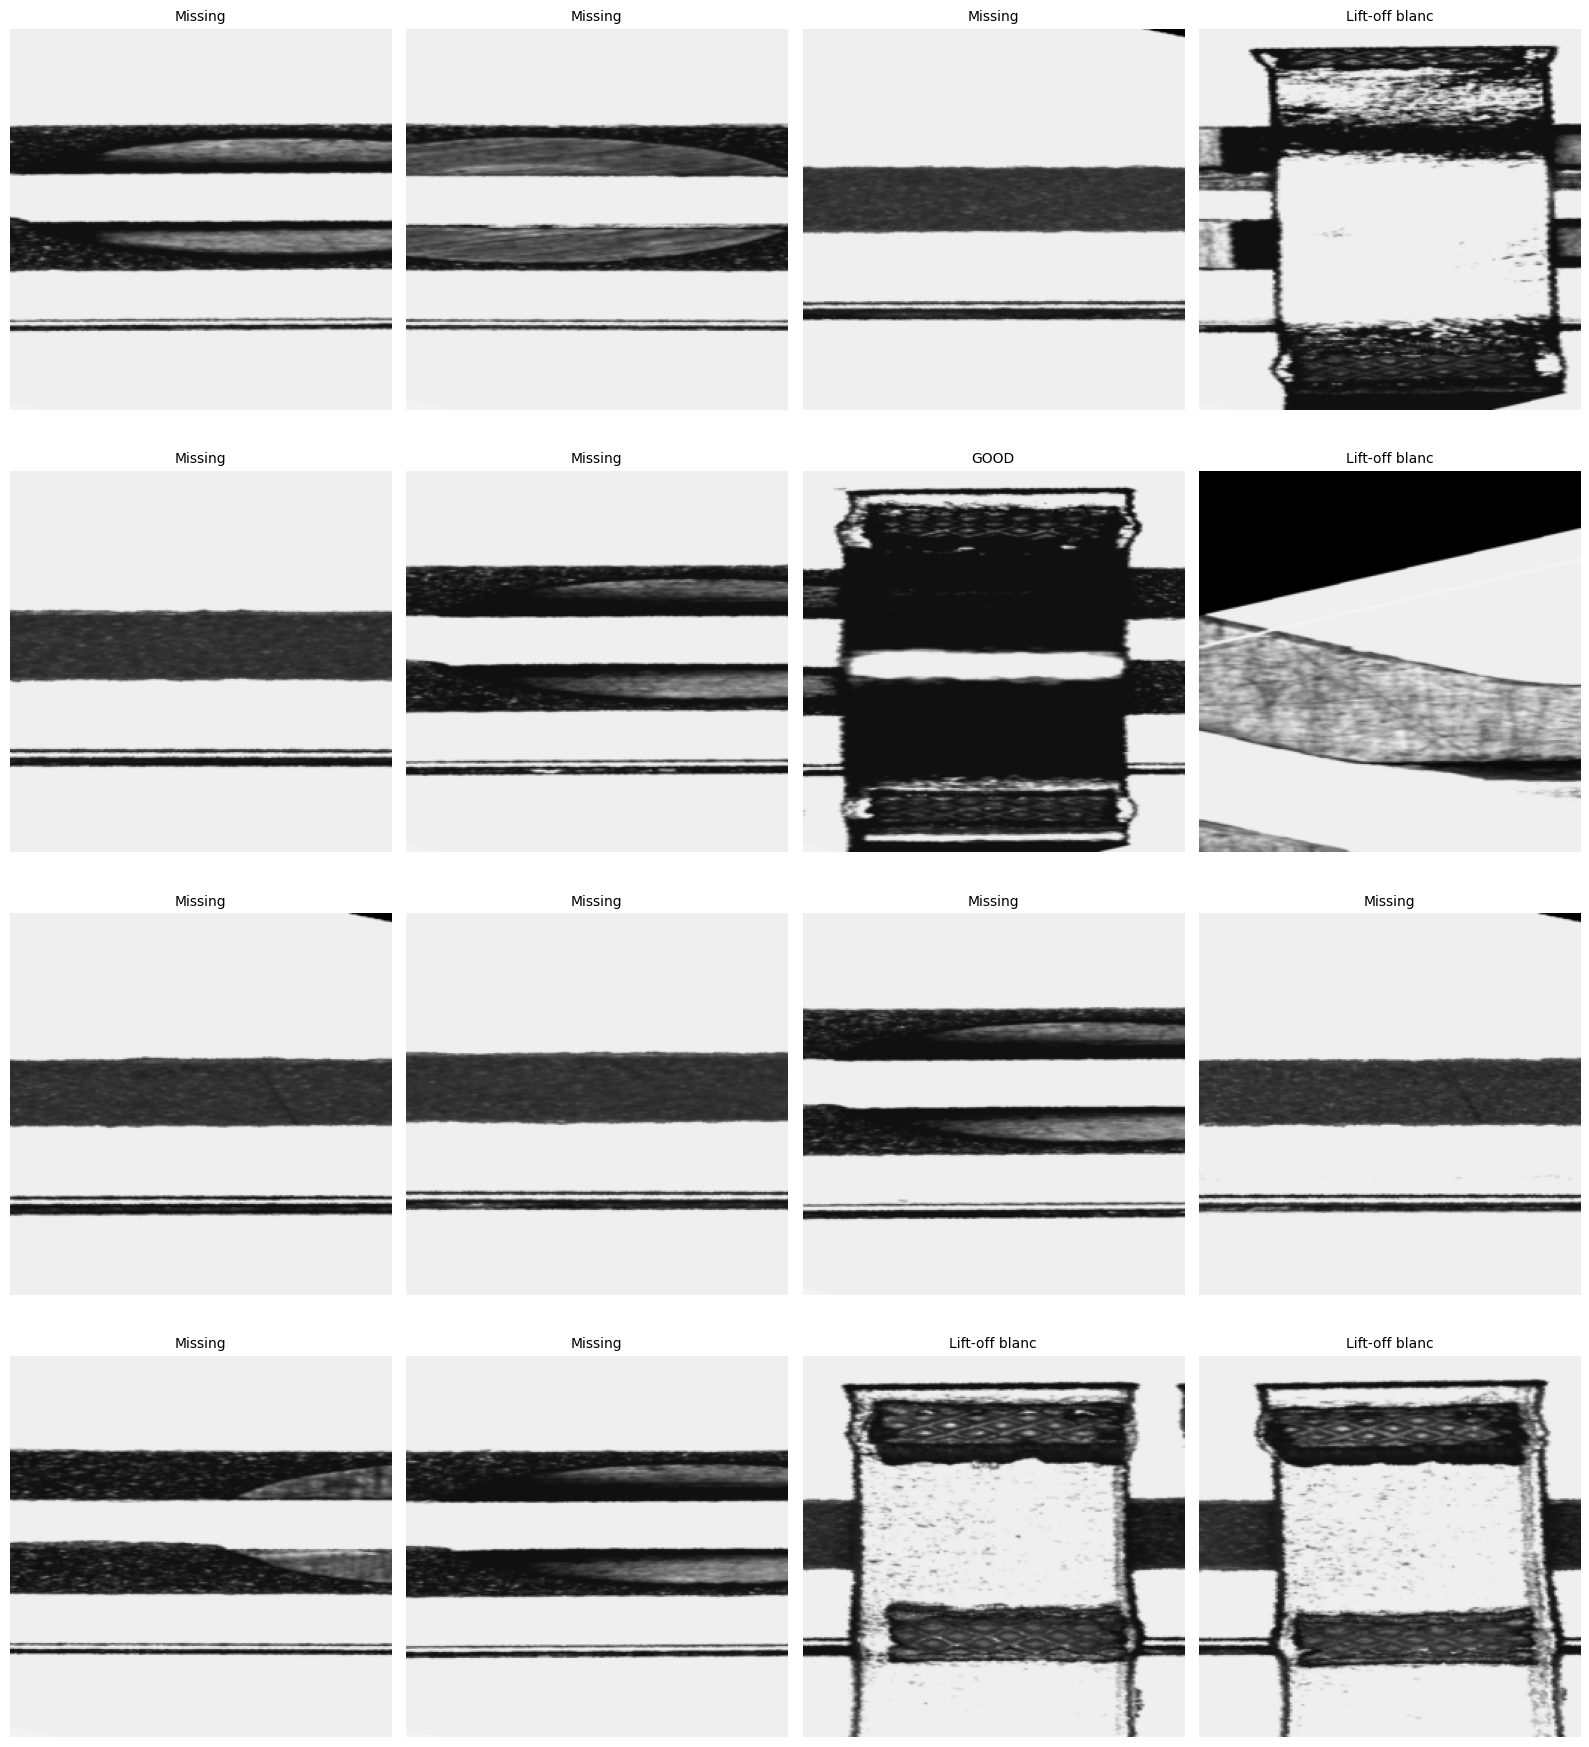

In [8]:
def show_image_grid(dataloader, label_map, num_images=16, grid_size=(4, 4)):
    images, labels = next(iter(dataloader))  # Get a batch of images and labels
    num_images = min(num_images, len(images))  # Limit to available images

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(16, 18))
    axes = axes.flatten()  # Flatten to iterate easily
    for i in range(num_images):
        img = FTV.to_pil_image(images[i])  # Convert tensor to PIL image
        label = labels[i].item()  # Get label as int
        
        axes[i].imshow(img)
        axes[i].set_title(label_map[label], fontsize=10)  # Use label_map to get class name
        axes[i].axis("off")  # Hide axes

    plt.tight_layout()
    plt.show()

show_image_grid(dataset_loader, map_idx_label)

In [9]:
label_counts = labeled_dataset.data["Label"].value_counts()

for label_name, count in label_counts.items():
    print(f"Class {label_name}: {count} images")

Class Missing: 6472 images
Class GOOD: 1235 images
Class Lift-off blanc: 270 images
Class Short circuit MOS: 126 images
Class Lift-off noir: 104 images
Class Boucle plate: 71 images


# General notes

- Dataset  : (inbalanced classes) (oversampling, undersampling, class weights

- Use IsolationForest maybe for detecting the drift class dans une approche non supervisée


- Une manière de lutter contre l'impact des données déséquilibrées consiste à modifier les fonctions de loss de telle manière que les données mal prédites de la classe minoritaire soient fortement pénalisées. La fonction de loss est pondérée pour chaque $x_i, y_i$ par un poids $w_i$. Pour la classification binaire la fonction de loss peut être définie comme ci-dessous:

    $L(\theta) = - \sum_{j=0}^{1} w_j \sum_{y_i=j} f(P(y_i|x_i, \theta))$

    Dans scikit-learn, les poids d'équilibrage sont calculés suivant cette formule:

    $w_j = \frac{N}{C * |y_i = j|_{i=1 \dots N}}$


# Data Augmentation

In [10]:
augment_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip
    transforms.RandomRotation(degrees=15),  # Rotate randomly within ±15°
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color variations
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Random distortions
    transforms.ToTensor(),  # Convert to tensor
])

augmented_dataset = cl.CustomImageDataset(true_labels, labeled_pictures, map_label_idx, transform=augment_transform)
aug_data_loader = DataLoader(augmented_dataset, batch_size=256, shuffle=True)

In [11]:
print(f"Dataset contains {len(augmented_dataset)} images.")

image, label = augmented_dataset[0]
print(f"Image shape: {image.shape}, Label: {label}")

Dataset contains 8278 images.
Image shape: torch.Size([3, 256, 256]), Label: 4


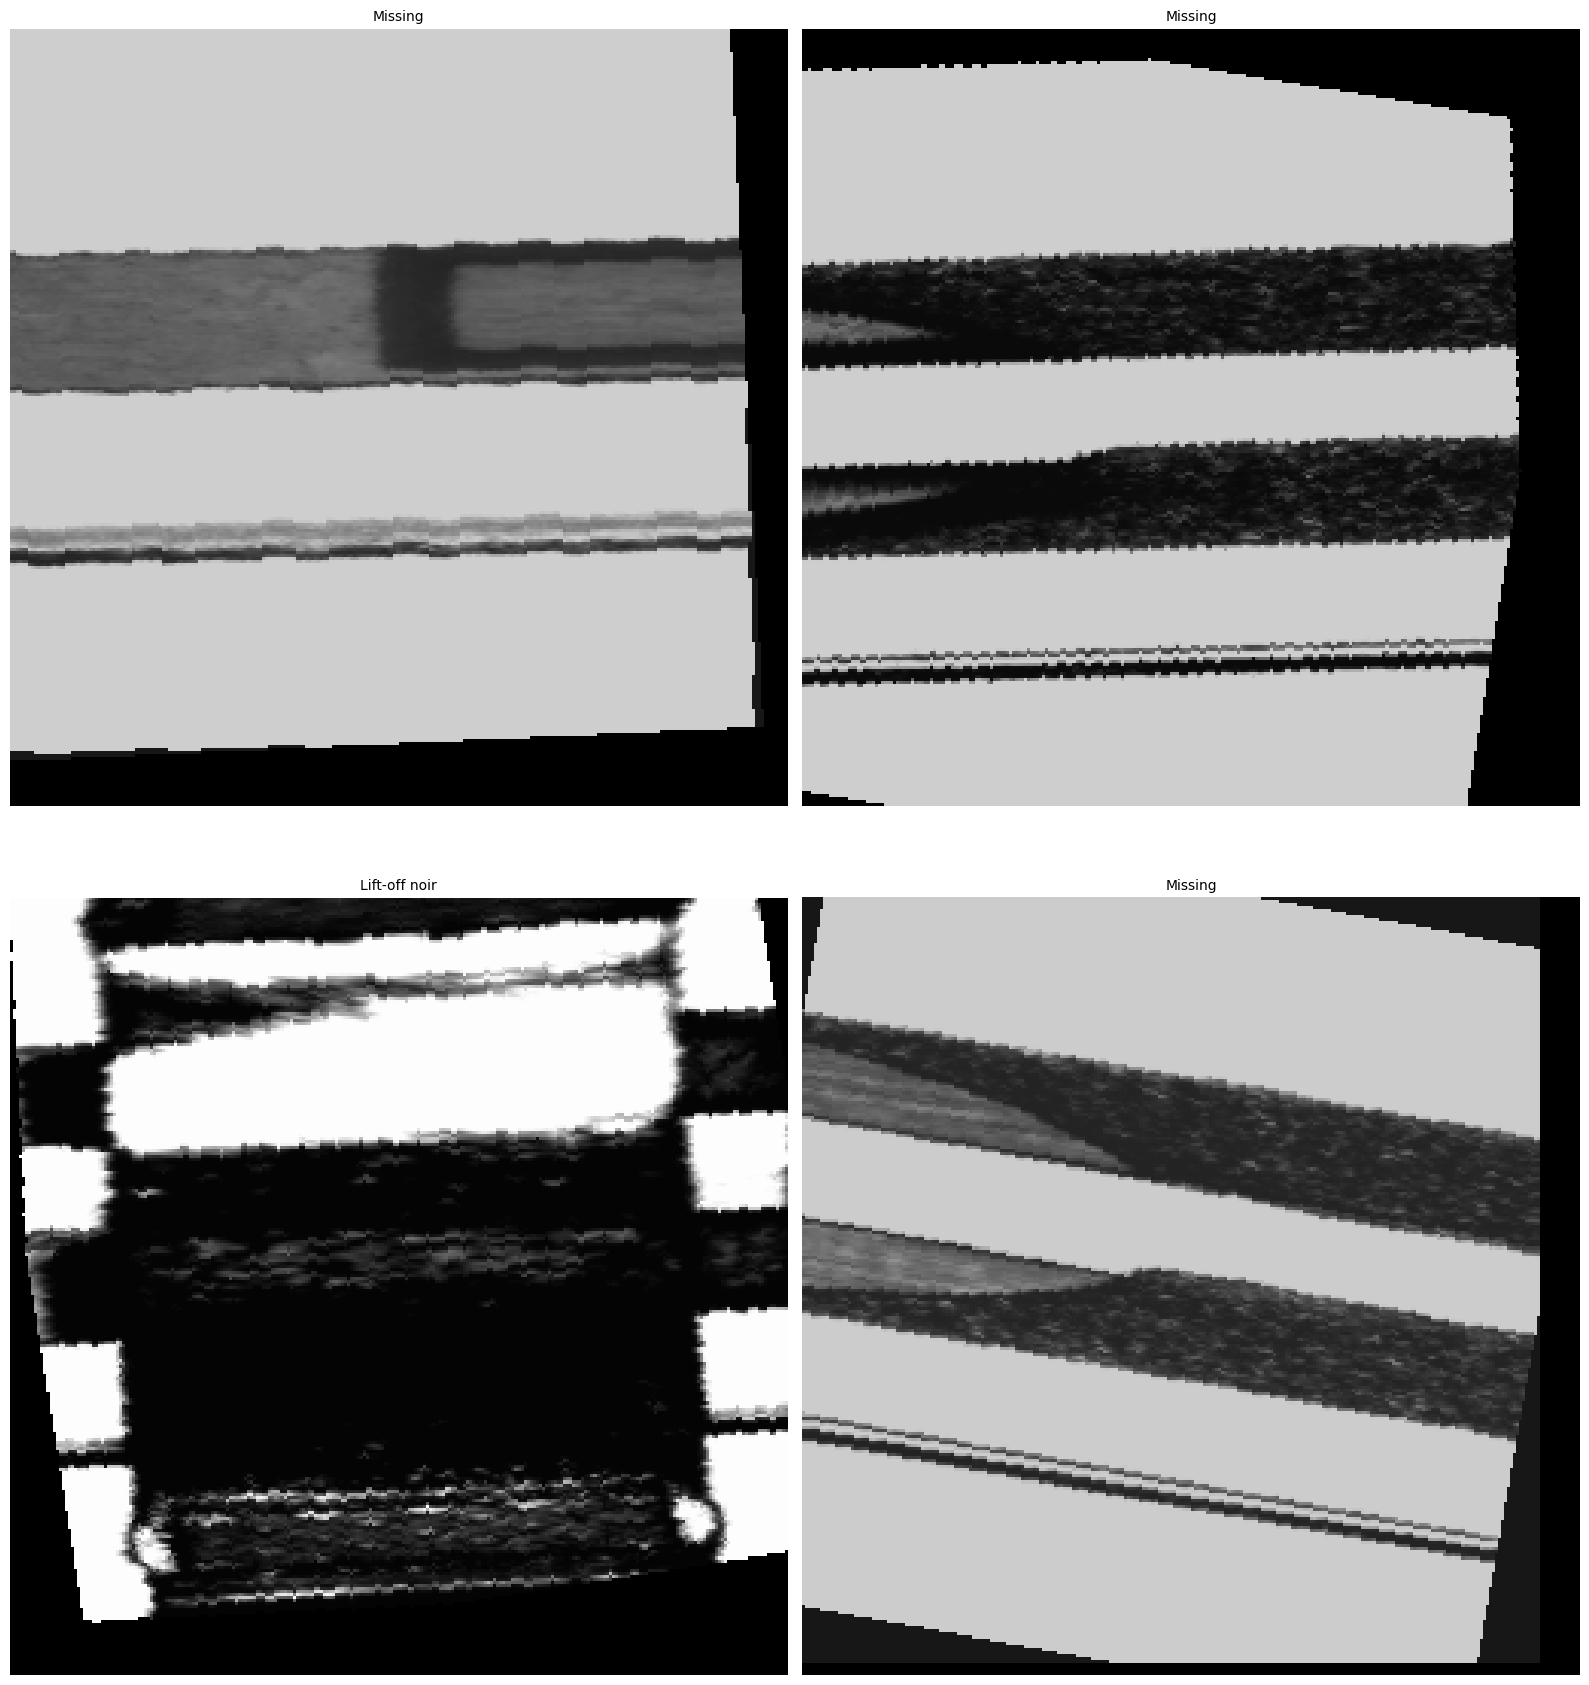

In [12]:
show_image_grid(aug_data_loader, map_idx_label, num_images=4, grid_size=(2, 2))

In [12]:
# Define split sizes (e.g., 80% train, 20% val)
train_size = int(0.8 * len(augmented_dataset))
val_size = len(augmented_dataset) - train_size

# Split dataset
train_subset, val_subset = random_split(augmented_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=256, shuffle=False)

print(f"Train samples: {len(train_subset)}, Validation samples: {len(val_subset)}")


Train samples: 6622, Validation samples: 1656


# First Try : Fine tune a ResNet

In [14]:
model = resnet18(pretrained=True)

# Modify the final fully connected layer to match your number of classes
num_ftrs = model.fc.in_features 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\mouad\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mouad\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(map_label_idx))

# we will try to finetune the last layer and the classification head
for param in model.fc.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

In [17]:
class_counts = torch.tensor(label_counts.values, dtype=torch.float)
class_counts

tensor([6472., 1235.,  270.,  126.,  104.,   71.])

In [18]:
# we compute the classical way of class weights, meaning we will give more important to underepresenated class
total_samples = class_counts.sum()
num_classes = len(class_counts)

class_weights = total_samples / (num_classes * class_counts)
class_weights

tensor([ 0.2132,  1.1171,  5.1099, 10.9497, 13.2660, 19.4319])

In [23]:
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4) # we only update the parametrs that are unfreezed

In [25]:
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images) 
        loss = criterion(outputs, labels) 
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item()
        train_loop.set_postfix(loss=loss.item()) # update the progress bar


    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # we fetch the max output
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            val_loop.set_postfix(loss=loss.item(), accuracy=(correct / total * 100))

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    accuracy = correct / total * 100

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.2f}%")

print("Training complete!")

Epoch [1/5] - Train Loss: 0.0077, Val Loss: 0.0469, Val Acc: 98.13%


Epoch [2/5] - Train Loss: 0.0080, Val Loss: 0.0391, Val Acc: 98.25%


Epoch [3/5] - Train Loss: 0.0067, Val Loss: 0.0320, Val Acc: 97.71%


Epoch [4/5] - Train Loss: 0.0096, Val Loss: 0.0328, Val Acc: 94.75%


Epoch [5/5] - Train Loss: 0.0077, Val Loss: 0.0414, Val Acc: 96.80%
Training complete!


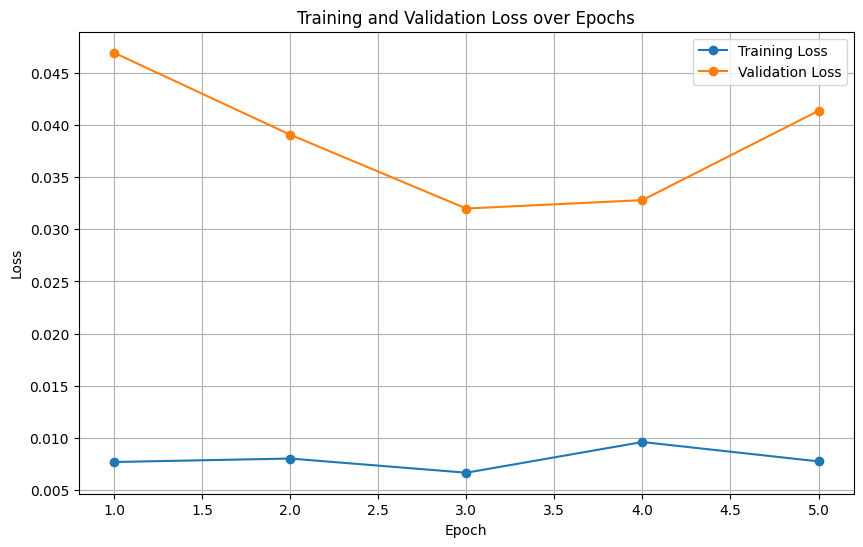

In [26]:
# visualize train and val erros, see also confusion matrix, ou peut être courbe ROC
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
all_labels = []
all_preds = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)


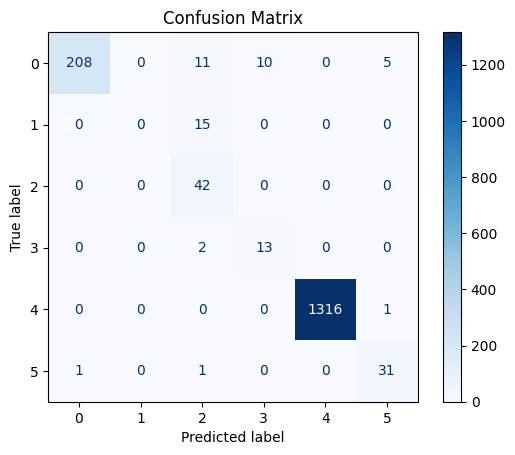

In [32]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5])  # Update with your class labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [41]:
# Save the model weights (state_dict)
iteration = 2
torch.save(model.state_dict(), f'model_weights_{iteration}.pth')
print("Model weights saved to 'model_weights.pth'")

Model weights saved to 'model_weights.pth'


# Load the test set and evaluate

In [13]:
# preprocess also the test dataset
transform = transforms.Compose([
                                transforms.Resize((256, 256)),  # Redimensionner les images
                                transforms.ToTensor(),            # Convertir en tenseur
                                ])
test_path= 'data\input_test'
test_dataset = c.CustomDataset(test_path, transform)
test_dataloader = DataLoader(test_dataset, batch_size=256, pin_memory=True)

In [34]:
model.eval()

all_predics = [] # contains tuples (filename, array of logits of length 6)
with torch.no_grad():
    for filenames, images in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        logits = outputs.cpu().numpy()
        all_predics.extend(zip(filenames, logits))

In [35]:
# to do, convert them to proba using softmax and then define a manual threshold for if never
# seen then new class, else then take the max index

results = []
threshold = 0.5
for image_path, logits_6 in all_predics:
    logits_7 = np.append(logits_6, 0)# Adding the dummy logit for 7th class
    logits_tensor = torch.tensor(logits_7)
    probabilities = F.softmax(logits_tensor, dim=0)
    # Check if the maximum probability is below the threshold for all known classes (first 6)
    max_prob = torch.max(probabilities[:6]).item()

    if max_prob < threshold:
        predicted_class = 6  # New class (class 7)
    else:
        predicted_class = torch.argmax(probabilities).item()
    results.append({
        'filename': image_path,
        'softmax': probabilities.numpy(),  # Convert tensor to numpy array for storage
        'Label': predicted_class,
    })

In [36]:
test_result_df = pd.DataFrame(results, columns=['filename', 'softmax', 'Label'])

In [37]:
test_result_df.head()

,filename,softmax,Label
0,003943cefade46399db0adf9e4a1a4f14ba55033770b92...,"[1.136765709576315e-06, 0.0013920464811900334,...",2
1,004acab8e86eced72f6aa676c83f58620365b249affa2b...,"[4.686716712521422e-06, 0.00018967863229871226...",2
2,0097035d8b03da345aab4afd2b95ff4c30c1d1f0d22cd2...,"[8.805594769393245e-08, 0.0004676776961744247,...",2
3,00c7e00fc6db3f9b53130689de8e895107cb501aebf499...,"[0.00011941331112536424, 0.04970682571764218, ...",2
4,0126d9e617c49a7829051ddd289cb4fef41e08f7f01ac9...,"[1.4762510212215211e-05, 0.0004193387257698758...",2


In [39]:
test_result_df['Label'].value_counts()

Label
2    970
3     78
6      7
Name: count, dtype: int64

In [ ]:
iteration = 2
test_result_df[['filename', 'Label']].to_csv(f'submissions\Y_test_submission_{iteration}.csv', index=True)